In [49]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

In [50]:
stocks = '^GSPC'
start = datetime.datetime(2013, 5, 1)
end = datetime.datetime(2023, 5, 1)
# s_p500 = yf.download(stocks, start=start, end = end, interval='1d')
# s_p500 = s_p500.to_json('s_p500.json')
s_p500 = pd.read_json('s_p500.json')
s_p500

,Open,High,Low,Close,Adj Close,Volume
2013-05-01,1597.550049,1597.550049,1581.280029,1582.699951,1582.699951,3530320000
2013-05-02,1582.770020,1598.599976,1582.770020,1597.589966,1597.589966,3366950000
2013-05-03,1597.599976,1618.459961,1597.599976,1614.420044,1614.420044,3603910000
2013-05-06,1614.400024,1619.770020,1614.209961,1617.500000,1617.500000,3062240000
2013-05-07,1617.550049,1626.030029,1616.640015,1625.959961,1625.959961,3309580000
...,...,...,...,...,...,...
2023-04-24,4132.069824,4142.410156,4117.770020,4137.040039,4137.040039,3290940000
2023-04-25,4126.430176,4126.430176,4071.379883,4071.629883,4071.629883,3978640000
2023-04-26,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3837030000
2023-04-27,4075.290039,4138.240234,4075.290039,4135.350098,4135.350098,3750550000


In [51]:
ret = 100 * (s_p500.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

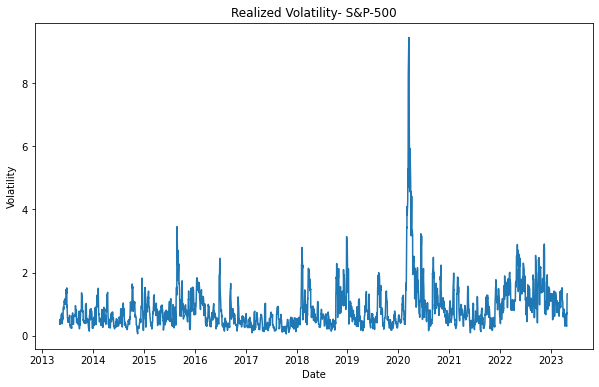

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol.index,realized_vol)
plt.title('Realized Volatility- S&P-500')
plt.ylabel('Volatility')
plt.xlabel('Date')
plt.show()

In [53]:
retv = ret.values

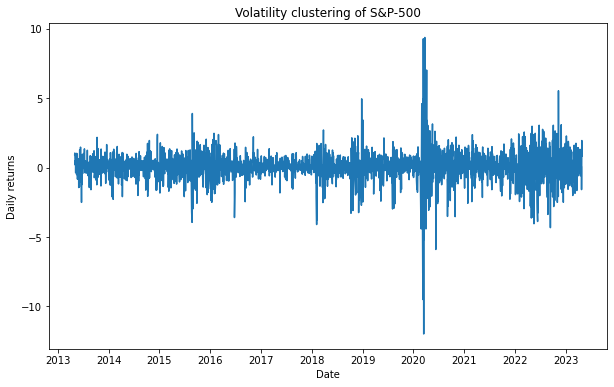

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(s_p500.index[1:], ret)
plt.title('Volatility clustering of S&P-500')
plt.ylabel('Daily returns')
plt.xlabel('Date')
plt.show()

In [55]:
n = 252
split_date = ret.iloc[-n:].index

In [56]:
sgm2 = ret.var()
K = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 *
                                (3.0 * sgm2 - K) * K)) / (6 * K) 
omega = (1 - alpha) * sgm2 
initial_parameters = [alpha, omega]
omega, alpha

(0.6705564329730168, 0.46091233032394135)

In [57]:
@jit(nopython=True, parallel=True) 
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0]) 
    alpha = abs(initial_parameters[1]) 
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv) 
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2 
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2)) 
    return logliks

In [58]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

1226.8185380229281

In [59]:
def opt_params(x0, retv):
    opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv),
                            method='Nelder-Mead',
                            options={'maxiter': 5000})
    params = opt_result.x
    print('\nResults of Nelder-Mead minimization\n{}\n{}'
        .format(''.join(['-'] * 28), opt_result))
    print('\nResulting params = {}'.format(params))
    return params

In [60]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
 final_simplex: (array([[0.63746576, 0.50532527],
       [0.63744384, 0.50540258],
       [0.6373828 , 0.5053489 ]]), array([1194.38023833, 1194.38023859, 1194.38024143]))
           fun: 1194.3802383257757
       message: 'Optimization terminated successfully.'
          nfev: 55
           nit: 29
        status: 0
       success: True
             x: array([0.63746576, 0.50532527])

Resulting params = [0.63746576 0.50532527]


In [61]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

In [62]:
sigma2_arch = arch_apply(ret)

In [63]:
arch = arch_model(ret, mean='zero', vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3506.40
Distribution:                  Normal   AIC:                           7016.81
Method:            Maximum Likelihood   BIC:                           7028.47
                                        No. Observations:                 2516
Date:                Thu, May 25 2023   Df Residuals:                     2516
Time:                        22:41:41   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6374  4.134e-02     15.418  1.243e-53 [  0.556,  0.71

In [64]:
bic_arch = []

for p in range(1, 5): 
        arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
                .fit(disp='off') 
        bic_arch.append(arch.bic)
        if arch.bic == np.min(bic_arch): 
            best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param)\
        .fit(disp='off') 
print(arch.summary())
forecast = arch.forecast(start=split_date[0]) 
forecast_arch = forecast

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3232.25
Distribution:                  Normal   AIC:                           6474.51
Method:            Maximum Likelihood   BIC:                           6503.66
                                        No. Observations:                 2516
Date:                Thu, May 25 2023   Df Residuals:                     2516
Time:                        22:41:41   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.2570  2.767e-02      9.288  1.569e-20 [  0.203,  0.31

In [65]:
rmse_arch = np.sqrt(mse(realized_vol[-n:] / 100,
                                 np.sqrt(forecast_arch\
                                 .variance.iloc[-len(split_date):]
                                 / 100)))
print('The RMSE value of ARCH model is {:.4f}'.format(rmse_arch))

The RMSE value of ARCH model is 0.1252


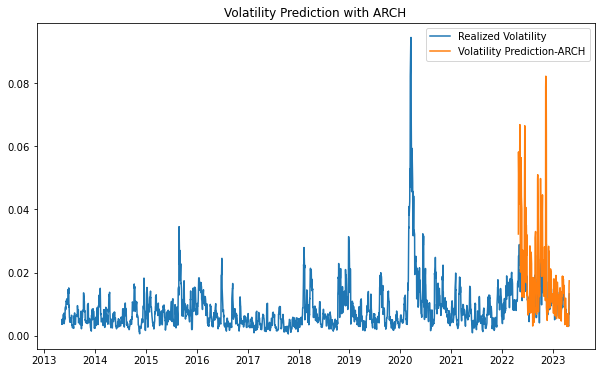

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label='Realized Volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100,
        label='Volatility Prediction-ARCH')
plt.title('Volatility Prediction with ARCH', fontsize=12)
plt.legend()
plt.show()